In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import IPython
import IPython.display

# Basic
import os
import datetime
import pandas as pd
import numpy as np

# Geometry
from pyefd import reconstruct_contour
from shapely.geometry import Polygon
from shapely.wkb import loads

# Local
from library import lib_aws, lib_dyna

# PLotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Scikit learn
from sklearn.preprocessing import StandardScaler

# Tensorflow
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')

# Data Querying and Pre-processing

This section inolves the following steps
- Querying the data from the db
- Setting up the dataframe with the necessary features
- Splitting the data into train, validation and test
- Normalizing the data if need be

**Note:** After querying `pocdowncard` is in a WKB format. This will be converted to a Shapely Polygon Object using the `shapely.wkb.loads` method.

In [3]:
%%time
well_name = 'Cook 12-13 6B'

query = """
SELECT 
    "NodeID",
    "Date",
    "pocdowncard",
    "Fillage",
    "SPM"
FROM
    xspoc.card
WHERE
    "NodeID" = '{}' AND
    "Date" BETWEEN '2018-03-19' AND '2020-05-26'
""".format(well_name)

with lib_aws.PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    

data.dropna(inplace=True)  # Nans arent present, but if they are will have to be dropped
# Converting the card data
data.pocdowncard = data.pocdowncard.apply(lambda x: loads(x, hex=True))
print("Queried Data")
display(data.head())

Connected to oasis-dev DataBase
Connection Closed
Queried Data


,NodeID,Date,pocdowncard,Fillage,SPM
0,Cook 12-13 6B,2019-03-19 00:12:48,"POLYGON ((5.670000076293945 -9814, 15.43000030...",94.8,3.1
1,Cook 12-13 6B,2019-03-19 00:55:33,"POLYGON ((6.440000057220459 -8749, 15.72000026...",44.9,1.4
2,Cook 12-13 6B,2019-03-19 02:52:18,"POLYGON ((2.640000104904175 -9096, 10.68999958...",49.4,1.4
3,Cook 12-13 6B,2019-03-19 03:09:29,"POLYGON ((5.119999885559082 -10034, 14.3500003...",98.4,3.1
4,Cook 12-13 6B,2019-03-19 04:20:22,"POLYGON ((3.849999904632568 -9043, 13.32999992...",52.8,1.4


Wall time: 13.8 s


In [40]:
"""
Extracting Fourier Descriptors And Setting up the initial Dataframe for windowing
Use the lib_dyna.Features class
"""

# Req
fd_order = 10
area = False
centroid = False

total_fd = fd_order*4

fea = lib_dyna.Features(df=data, well_col='NodeID', card_col='pocdowncard')  # setup the class
fea.remove_errors()  # removes cards where fd cannot be found
bounds = fea.all_bounds()  # gets the bounds, which can help with the initial normalization of the cards
fd = fea.get_X(fd_order=fd_order, area=area, centroid=centroid, normalize_fn='df', norm_arg=bounds)  # get fd dataframe

# if data points were removed those are reflected in the main datafrae as well
if fd.shape[0] != data.shape[0]:
    data = fea.df.copy()  

fd_df = pd.DataFrame(index = data.Date, data=fd)

if area is True:
    col_mapper = dict(zip(range(total_fd, total_fd+3), ['Area', 'CentX', 'CentY']))
else:
    col_mapper = dict(zip(range(total_fd, total_fd+2), ['CentX', 'CentY']))
    
fd_df.rename(columns=col_mapper, inplace=True)
display(fd_df.head())

Total errors found in 0 datapoints


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-19 00:12:48,-0.288901,0.259571,-0.268508,-0.261953,0.001880,-0.009000,-0.005704,0.009348,-0.027704,-0.024360,...,-0.000877,-0.003374,-0.001929,0.004271,-0.004108,-0.003043,0.000229,-0.000661,-0.000517,0.001982
2019-03-19 00:55:33,-0.264557,0.150317,-0.296912,-0.157263,0.061512,0.014319,-0.055591,-0.032235,-0.042656,0.020647,...,-0.000159,-0.003758,0.000779,0.001601,-0.005848,-0.000131,-0.001980,0.000237,0.001638,-0.003518
2019-03-19 02:52:18,-0.251294,0.158126,-0.312700,-0.159757,0.059592,0.014965,-0.049427,-0.027636,-0.047991,0.017283,...,-0.000120,-0.003572,-0.000658,0.002236,-0.005527,0.000149,-0.001564,0.000344,0.001203,-0.003225
2019-03-19 03:09:29,-0.282435,0.268266,-0.288111,-0.272145,-0.001138,-0.013308,-0.006128,0.013534,-0.029025,-0.027490,...,-0.003073,-0.003717,-0.001564,0.003643,-0.005105,-0.003304,0.000190,-0.001008,0.000552,0.000775
2019-03-19 04:20:22,-0.248752,0.162862,-0.317136,-0.177195,0.059210,0.019797,-0.050327,-0.031273,-0.054940,0.014986,...,-0.000126,-0.005174,-0.000730,0.002187,-0.005194,-0.000268,-0.001501,-0.000147,0.002442,-0.003196


In [41]:
# additional_cols = ['Fillage', 'SPM']
additional_cols = None

if additional_cols is not None:
    feature_df = pd.concat([fd_df, data.set_index("Date").reindex(fd_df.index)[['Fillage', 'SPM']]], axis=1)  # Specifiy the c
else:
    feature_df = fd_df.copy()

In [55]:
"""
Normalizing the Data
"""
class SplitAndNorm:
    
    def __init__(self, df, extra_features=None, test_split=0.7, val_split=0.2):
        self.df = df
        self.extra_features = extra_features
        self.test_split = test_split
        self.val_split = val_split
        self.all_columns = df.columns
        
    def split(self):
        n = len(self.df)
        self.train_df = self.df[0: int(n *self.test_split)]
        self.val_df = self.df[int(n * self.test_split): int(n * (self.test_split + self.val_split))]
        self.test_df = self.df[int(n*(self.test_split + self.val_split)):]
        
    def norm(self):
        
        if self.extra_features is None:
            self.scaler = StandardScaler()
            train_sc = self.scaler.fit_transform(self.train_df)
            val_sc = self.scaler.transform(self.val_df)
            test_sc = self.scaler.transform(self.test_df)

            self.train_df = pd.DataFrame(data=train_sc, index=self.train_df.index)
            self.val_df = pd.DataFrame(data=val_sc, index=self.val_df.index)
            self.test_df = pd.DataFrame(data=test_sc, index=self.test_df.index)
            
        if self.extra_features is not None:
            self.scaler = StandardScaler()
            scaler2 = StandardScaler()
            
            train1 = self.scaler.fit_transform(self.train_df.drop(columns = self.extra_features))
            train2 = scaler2.fit_transform(self.train_df[self.extra_features])
            self.train_df = pd.DataFrame(index=self.train_df.index, data=np.hstack([train1, train2]), columns=self.all_columns)
            
            val1 = self.scaler.transform(self.val_df.drop(columns = self.extra_features))
            val2 = scaler2.transform(self.val_df[self.extra_features])
            self.val_df = pd.DataFrame(index=self.val_df.index, data=np.hstack([val1, val2]), columns=self.all_columns)
            
            test1 = self.scaler.transform(self.test_df.drop(columns = self.extra_features))
            test2 = scaler2.transform(self.test_df[self.extra_features])
            self.test_df = pd.DataFrame(index=self.test_df.index, data=np.hstack([test1, test2]), columns=self.all_columns)

In [56]:
extra_features = None
sn = SplitAndNorm(df=feature_df, extra_features=extra_features)
sn.split()
sn.norm()

In [57]:
sn.train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-19 00:12:48,-1.476385,0.726016,1.340574,-0.539667,-0.957349,-1.258158,0.762266,1.193613,1.406450,-0.945333,...,-0.124021,0.088201,-1.058984,1.657931,0.153180,-0.851005,1.041003,-0.966399,-1.333984,1.739075
2019-03-19 00:55:33,-0.302690,-1.493648,0.561372,1.251537,1.266648,1.046559,-1.056102,-0.859013,0.048088,1.120042,...,0.272861,-0.072557,0.491697,0.142758,-1.060509,0.196180,-1.285411,0.333053,0.295498,-1.033494
2019-03-19 02:52:18,0.336726,-1.334995,0.128261,1.208878,1.195060,1.110391,-0.831425,-0.631981,-0.436521,0.965689,...,0.294486,0.005331,-0.331029,0.503234,-0.836343,0.296760,-0.847709,0.487438,-0.033929,-0.885840
2019-03-19 03:09:29,-1.164665,0.902672,0.802802,-0.714045,-1.069942,-1.683925,0.746785,1.400247,1.286427,-1.088993,...,-1.337434,-0.055331,-0.849893,1.301562,-0.542468,-0.944777,0.999771,-1.467481,-0.525846,1.130778
2019-03-19 04:20:22,0.459304,-1.238773,0.006552,0.910509,1.180801,1.587896,-0.864207,-0.811535,-1.067878,0.860256,...,0.291055,-0.665582,-0.372424,0.475279,-0.604047,0.146938,-0.780862,-0.221618,0.903491,-0.871093


In [ ]:
### Testing SplitAndNorm
# pd.DataFrame(sn.scaler.inverse_transform(sn.train_df))
# test = pd.DataFrame(sn.scaler.inverse_transform(sn.val_df.iloc[:,:-2]), index=sn.val_df.index)
# test = test.round(5)

# test2 = feature_df.loc[sn.val_df.index].drop(columns=sn.extra_features)
# test2  = test2.round(5)
# test2.equals(test)

## Windowing our Data

Parameters Used:
- time_window : Points within this time delta are considered for windowing
- input_width : Number of datapoints for the input
- label_width : Number of labels forecasted
- shift       : The offset from the input_width to the label width

Now, the Total window size will be `input_width + shift`. This `total_window_size` needs to lie within the `time_window`.

In [25]:
class WindowGenerator():
    
    def __init__(self, time_window, input_width, label_width, shift,
                train_df, val_df, test_df,
                non_label_columns=None):
    
        # Storing the DataFrames
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Label columns (Will Help Generalize the class)
        all_cols = train_df.columns.astype('str').values
        self.non_label_columns = non_label_columns
        self.label_columns = np.setdiff1d(all_cols, non_label_columns)
        self.label_column_indices = {name: i for i, name in enumerate(self.label_columns)}
        self.column_indices = {name: i for i, name in enumerate(all_cols)}

        # Setup parameters
        self.time_window = pd.Timedelta(time_window)
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
    
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}',
            f'Dropped column name(s): {self.non_label_columns}'])
    
    
    def make_dataset(self, data, batch_size=500, output_time = False):
        dataset = []  # Intialize the windowed array
        time_index = []  # to get the timestamps (will help while plotting)

        c = 0  # count the number of discarded data points
        
        for t in data.index:
            time_chunk = data[t: t+self.time_window]  # Get the data chunk in the time_window

            # datapoints in the time window should be atleast the size of the window
            if len(time_chunk) >= self.total_window_size: 
                dataset.append(time_chunk.iloc[0: self.total_window_size].values)  # To have constant windows 
                time_index.append(time_chunk.iloc[self.label_start: self.total_window_size].index.values)
            else:
                c+=1

        print(f'No of data points discarded {c}')
        dataset = tf.convert_to_tensor(dataset)
        
        # Split into inputs and outputs
        inputs = dataset[:, self.input_slice, :]
        labels = dataset[:, self.label_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
            
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))
        dataset = dataset.batch(batch_size)
        
        del inputs
        del labels
        
        if output_time:
            time_index = np.array(time_index)
            return time_index
        else:
            return dataset
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def train_index(self):
        return self.make_dataset(self.train_df, output_time=True)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def val_index(self):
        return self.make_dataset(self.val_df, output_time=True)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def test_index(self):
        return self.make_dataset(self.test_df, output_time=True)

    @property
    def example(self):
        """
        Get and cache an example batch of `inputs, labels` for plotting.
        """
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        
        return result
    
    
    def plot(self, model=None, plot_col='0', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)
        
            label_col_index = self.label_column_indices.get(plot_col, None)

            plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

In [58]:
w1 = WindowGenerator(time_window='24H', input_width=7, label_width=1, shift=1,
                    train_df = sn.train_df,
                    val_df = sn.val_df,
                    test_df = sn.test_df,
                    non_label_columns = extra_features)

w1

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '5' '6' '7' '8' '9']
Dropped column name(s): None

In [109]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    print('-------')

No of data points discarded 309
Inputs shape (batch, time, features): (500, 7, 40)
Labels shape (batch, time, features): (500, 1, 40)
-------


In [107]:
ds = w1.train.take(1)

No of data points discarded 309


In [108]:
ds.element_spec

(TensorSpec(shape=(None, 7, 40), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 40), dtype=tf.float64, name=None))

## Building the Model

In [60]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=30):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    
    return history

In [119]:
x = w1.test

No of data points discarded 68


In [120]:
for a, b in x.take(1):
    print(a.numpy().shape)
    print(b.numpy().shape)

(294, 7, 40)
(294, 1, 40)


In [97]:
x = x.prefetch(1)

In [101]:
for a,b in x:
    test_x = a.numpy()
    print(a.numpy())
    print("NXT")

[[[-1.47638549  0.7260164   1.34057353 ... -0.96639863 -1.33398389
    1.73907525]
  [-0.30269008 -1.49364843  0.56137192 ...  0.33305257  0.29549784
   -1.03349437]
  [ 0.33672617 -1.33499531  0.1282611  ...  0.48743784 -0.03392882
   -0.88583966]
  ...
  [ 0.45930357 -1.23877313  0.00655155 ... -0.22161819  0.90349144
   -0.87109298]
  [-0.72730396  0.9573961   0.58661896 ... -0.76791455 -0.46972831
    0.9998207 ]
  [ 0.2268655  -1.42893835  0.0263596  ...  0.18128508  0.26197611
   -0.67523134]]

 [[-0.30269008 -1.49364843  0.56137192 ...  0.33305257  0.29549784
   -1.03349437]
  [ 0.33672617 -1.33499531  0.1282611  ...  0.48743784 -0.03392882
   -0.88583966]
  [-1.16466534  0.90267186  0.80280175 ... -1.467481   -0.52584615
    1.13077809]
  ...
  [-0.72730396  0.9573961   0.58661896 ... -0.76791455 -0.46972831
    0.9998207 ]
  [ 0.2268655  -1.42893835  0.0263596  ...  0.18128508  0.26197611
   -0.67523134]
  [-1.3829505   0.56806538  1.16627718 ... -0.51228603  0.41753906
    0.

In [100]:
test_x.shape

(500, 7, 40)

In [30]:
# Compile Metrics
val_performance = {}
performance = {}

### LSTM Model

In [112]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(len(w1.label_column_indices))
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(w1.test, epochs=100, verbose=1)

No of data points discarded 68
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1/1 [==============================] - 0s 0s/step - loss: 2.2446
Epoch 2/100
1/1 [==============================] - 0s 0s/step - loss: 2.2446
Epoch 3/100
1/1 [==============================] - 0s 0s/step - loss: 2.2446
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 2.2446
Epoch 5/100
1/1 [==============================] - 0s 0s/step - loss: 2.2446
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 2.2446
Epoch 7/100
1/1

In [139]:
len(w1.label_column_indices)

40

In [61]:
# Model Structure
tf.keras.backend.clear_session()
lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, Features]
    tf.keras.layers.GRU(200, return_sequences=True),
    tf.keras.layers.GRU(100, return_sequences=True),
    tf.keras.layers.GRU(80),
    tf.keras.layers.Dense(len(w1.label_column_indices))
])

In [62]:
lstm_history = compile_and_fit(lstm_model, w1)
IPython.display.clear_output()

val_performance['LSTM_GRU'] = lstm_model.evaluate(w1.val, verbose=1)
performance['LSTM_GRU'] = lstm_model.evaluate(w1.test, verbose=1)

No of data points discarded 52
2/2 [==============================] - 0s 8ms/step - loss: 1.9954 - mean_absolute_error: 1.0463
No of data points discarded 68
1/1 [==============================] - 0s 0s/step - loss: 1.9137 - mean_absolute_error: 1.0624


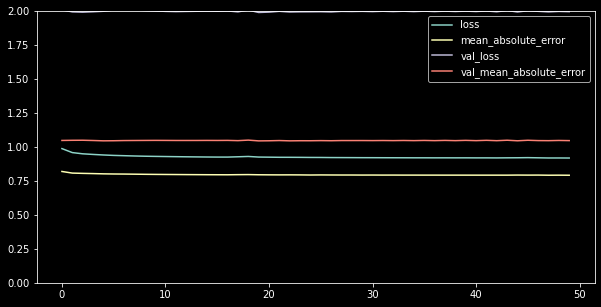

In [65]:
pd.DataFrame(lstm_history.history).plot(figsize=(10,5))
# plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [113]:
"""
Predictions
"""
# Get Predictions
y_pred = lstm_model.predict(w1.test)  # predict
y_pred = sn.scaler.inverse_transform(y_pred)  # re-scale

# Get index
pred_index = w1.test_index
pred_index = pred_index.reshape(pred_index.shape[0])

# Prediction Dataframe
y_pred_df = pd.DataFrame(data=y_pred, index=pred_index)

No of data points discarded 68
No of data points discarded 68


In [117]:
y_pred.shape

(294, 40)

2020-02-25 12:04:53


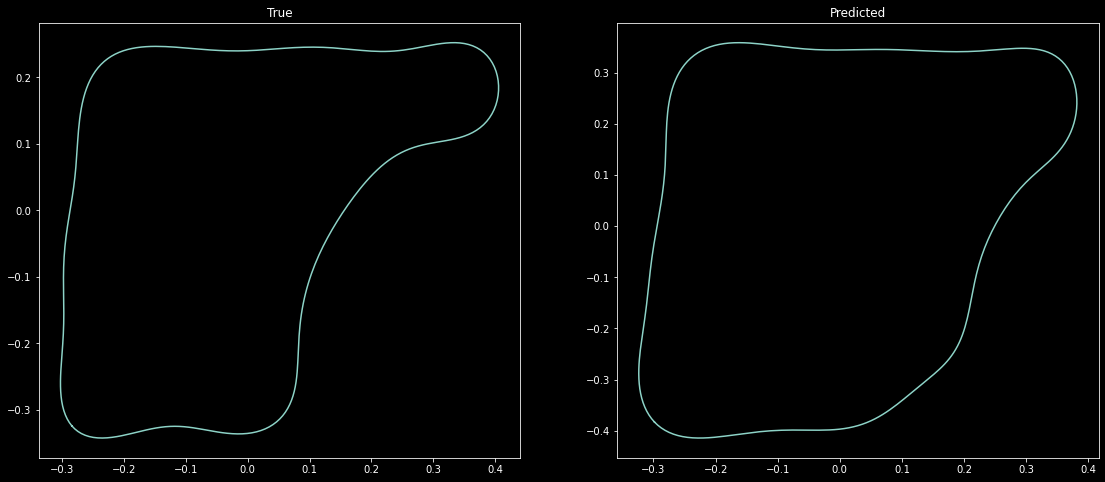

In [75]:
"""
Plotting
"""
index = 3
predicted_time = y_pred_df.index[index]
print(predicted_time)

# Pred
pred_fd = y_pred_df.loc[predicted_time].values.reshape(fd_order,4)
pred_xy = reconstruct_contour(pred_fd)

# True
true_fd = fd_df.loc[predicted_time].values.reshape(fd_order,4)
true_xy = reconstruct_contour(true_fd)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(19,8))
ax1.plot(true_xy[:,0], true_xy[:,1], label='True')
ax1.set_title('True')
ax2.plot(pred_xy[:,0], pred_xy[:,1], label='Predicted')
ax2.set_title('Predicted')
plt.show()

# Notes

- Initaily Normalizing the fd gives cleaner outputs
- This Norm was done using 'df' method
- Can also try using different methods

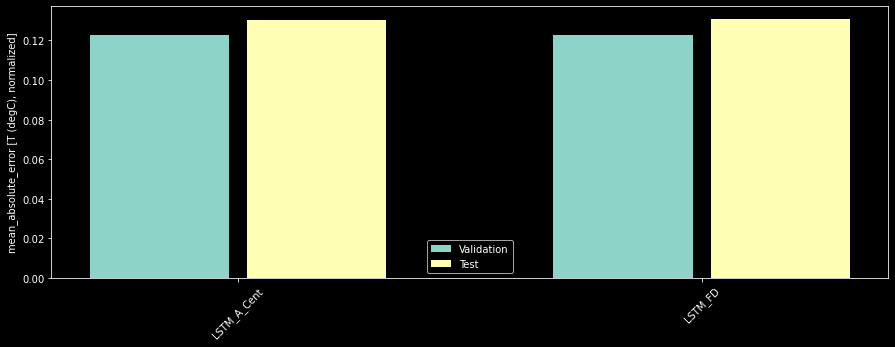

In [54]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Single Step Models

In [ ]:
## Single Step Model
single_step_window = WindowGenerator(time_window='30H', input_width=10, label_width=1, shift=1,
                                    train_df = train_df,
                                    val_df = val_df,
                                    test_df = test_df,
                                    non_label_columns=['1', '2', '3'])

single_step_window

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

## Baseline

This Baseline returns the current 0th Fd as the prediction

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]  ## Understant it

In [ ]:
baseline = Baseline(label_index=0)  # index of the column

baseline.compile(loss = tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])



val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

In [ ]:
## Single Step Model
wide_window = WindowGenerator(time_window='30H', input_width=10, label_width=10, shift=1,
                                    train_df = train_df,
                                    val_df = val_df,
                                    test_df = test_df,
                                    non_label_columns=['1', '2', '3'])

wide_window

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

In [ ]:
wide_window.plot(baseline)

# Multi-Output

In [ ]:
multi_output = WindowGenerator(time_window='30H', input_width=10, label_width=1, shift=1,
                                    train_df = train_df,
                                    val_df = val_df,
                                    test_df = test_df)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

multi_output

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=4)
])

history = compile_and_fit(dense, multi_output)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(multi_output.val)
performance['Dense'] = dense.evaluate(multi_output.test, verbose=0)

In [ ]:
%%time
tf.keras.backend.clear_session()
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(200, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(80),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=4)
])

history = compile_and_fit(lstm_model, multi_output)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( multi_output.val)
performance['LSTM'] = lstm_model.evaluate( multi_output.test, verbose=0)

print()

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        4,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, multi_output)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(multi_output.val)
performance['Residual LSTM'] = residual_lstm.evaluate(multi_output.test, verbose=0)
print()

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,5))
# plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

## Understanding

In [ ]:
time_window = '30H'
input_width = 10
label_width = 1
shift = 1

total_window_size = input_width + shift  # total window size
label_start = total_window_size - label_width  # Label Start index
time_window = pd.Timedelta(time_window)

In [ ]:
input_slice = slice(0, input_width)
label_slice = slice(label_start, None)

In [ ]:
# Getting full windows as a numpy array
# will be a 3d array
# (batch, timestep, features)

td = val_df.copy()
td.shape

In [ ]:

total_window_size

t1 = np.array([1,2,3])
t2 = np.array([4,5,6])

# tf.concat([t1,t2], axis=1)

tf.stack([t1,t2])

In [ ]:
custom_window = []  # Intialize the windowed array
time_index = []  # to get the timestamps (will help while plotting)

c = 0  # count the number of discarded data points

for t in td.index:
    time_chunk = td[t: t+time_window]  # Get the data chunk in the time_window
    
    # datapoints in the time window should be atleast the size of the window
    if len(time_chunk) >= total_window_size: 
        custom_window.append(time_chunk.iloc[0:total_window_size].values)  # To have constant windows 
    
    else:
        c+=1
        
print(f'No of data points discarded {c}')
custom_window = tf.convert_to_tensor(custom_window)

In [ ]:
# Splitting

inputs = custom_window[:, input_slice, :]
labels = custom_window[:, label_slice, :]


# Create a mapping to keep only those indixes from the labels we need

inputs.set_shape([None, input_width, None])
labels.set_shape([None, label_width, None])

In [ ]:
ds =tf.data.Dataset.from_tensor_slices((inputs, labels))

In [ ]:
ds

In [ ]:
batch_size = 32
shuffle_buffer_size = 500

ds = ds.shuffle(shuffle_buffer_size).batch(batch_size)

In [ ]:
for example_inputs, example_labels in ds.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
tf.data.Dataset.from_tensor_slices()

In [ ]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
  data=twin,
  targets=None,
  sequence_length=total_window_size,
  sequence_stride=1,
  shuffle=True,
  batch_size=32,)

In [ ]:
plot_index = 2 # Oth fd

input_indices = np.arange(total_window_size)[input_slice]
label_indices = np.arange(total_window_size)[label_slice]

max_subplots=3
plt.figure(figsize=(12, 8))
plot_col_index = plot_index
max_n = min(max_subplots, len(inputs))

for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel('0th FD [normed]')
    plt.plot(input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.',
            zorder=-10)
    
    label_col_index = 0
    
    plt.scatter(label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels',
               c='#2ca02c', s=64)
    
    if n == 0:
        plt.legend()

In [ ]:
tf.data.Dataset.from_tensors(inputs)

# Testing

In [122]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

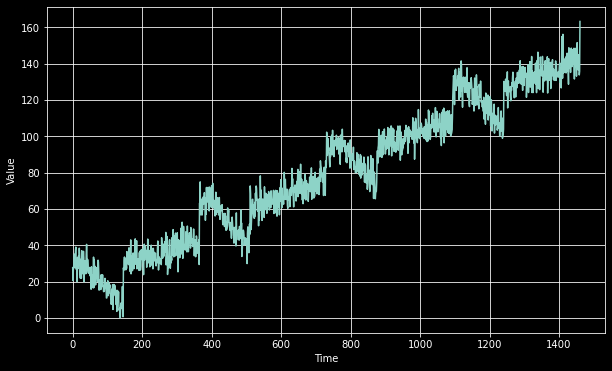

In [123]:
# Create a 2d Series
time = np.arange(4 * 365 + 1, dtype="float32")

# First Series
baseline1 = 10
amplitude1 = 20
slope1 = 0.09
period1 = 365  
noise_level1 = 5

series1 = baseline1 + trend(time, slope=slope1) + seasonality(time, period=period1, amplitude=amplitude1)
series1 += noise(time, noise_level=noise_level1, seed=420)

# Plot the first series
plt.figure(figsize=(10, 6))
plot_series(time, series1)

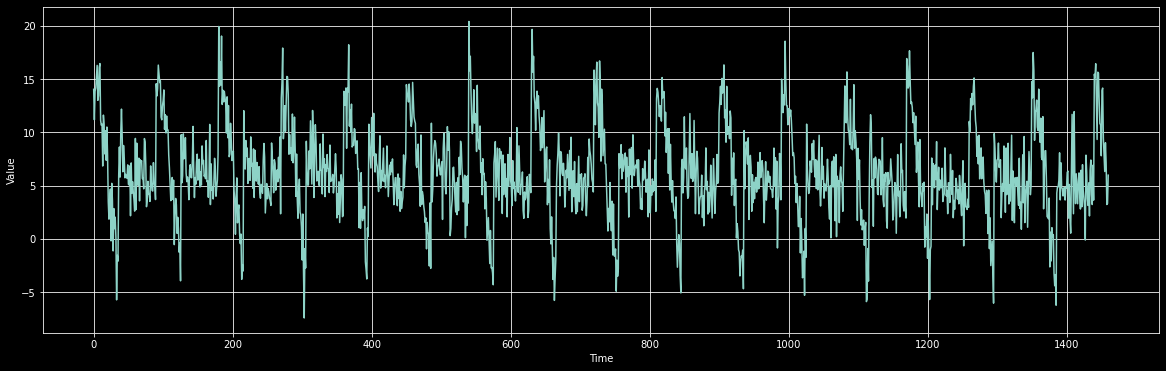

In [124]:
# Second Series
baseline2 = 5
amplitude2 = 10
slope2 = -0.001
period2 = 90  
noise_level2 = 2

series2 = baseline2 + trend(time, slope=slope2) + seasonality(time, period=period2, amplitude=amplitude2)
series2 += noise(time, noise_level=noise_level2, seed=420)

# Plot the first series
plt.figure(figsize=(20, 6))
plot_series(time, series2)

In [128]:
split_time = 1000
series = np.column_stack([series1, series2])
x_train = series[:split_time]
x_valid = series[split_time:]

In [131]:
x_valid.shape

(461, 2)

In [132]:
input_size = 50
label_size = 1
win_size = input_size + label_size

x = []
y = []

for i in range(len(x_train)):
    window = x_train[i: i+win_size]
    if len(window) >= win_size:
        x.append(window[0: input_size])
        y.append(window[input_size:win_size])

x = np.array(x)
y = np.array(y)

dataset = tf.data.Dataset.from_tensor_slices((x,y))
dataset = dataset
dataset = dataset.batch(32)

In [133]:
input_size = 50
label_size = 1
win_size = input_size + label_size

x_val = []
y_val = []

for i in range(len(x_valid)):
    window = x_valid[i: i+win_size]
    if len(window) >= win_size:
        x_val.append(window[0: input_size])
        y_val.append(window[input_size:win_size])

x_val = np.array(x_val)
y_val = np.array(y_val)

dataset_val = tf.data.Dataset.from_tensor_slices((x_val,y_val))
dataset_val = dataset_val.batch(32)

In [167]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
#     tf.keras.layers.LSTM(100, return_sequences=True),
#     tf.keras.layers.LSTM(8),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=2),
#     tf.keras.layers.Reshape([-1,1])
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 0s 1ms/step - loss: 226.9758
Epoch 2/100
30/30 [==============================] - 0s 800us/step - loss: 83.6798
Epoch 3/100
30/30 [==============================] - 0s 1ms/step - loss: 65.9617
Epoch 4/100
30/30 [==============================] - 0s 1ms/step - loss: 61.1382
Epoch 5/100
30/30 [==============================] - 0s 905us/step - loss: 57.7938
Epoch 6/100
30/30 [==============================] - 0s 1ms/step - loss: 55.2936
Epoch 7/100
30/30 [==============================] - 0s 1ms/step - loss: 53.5694
Epoch 8/100
30/30 [==============================] - 0s 1ms/step - loss: 51.7861
Epoch 9/100
30/30 [==============================] - 0s 799us/step - loss: 50.3618
Epoch 10/100
30/30 [==============================] - 0s 886us/step - loss: 49.0475
Epoch 11/100
30/30 [==============================] - 0s 1ms/step - loss: 48.0601
Epoch 12/100
30/30 [==============================] - 0s 1ms/step - loss: 47.0813
Epoch 13/100
30/

In [182]:
# y_pred2 = model.predict(x_val)
y_val[:,:,0]

array([[109.70064 ],
       [102.42494 ],
       [105.970436],
       [105.32156 ],
       [104.66345 ],
       [107.89368 ],
       [112.45115 ],
       [108.11946 ],
       [101.44401 ],
       [ 98.939804],
       [106.89968 ],
       [ 94.85603 ],
       [111.72153 ],
       [113.14694 ],
       [107.25124 ],
       [114.478874],
       [108.63722 ],
       [ 99.78591 ],
       [115.471085],
       [ 96.34188 ],
       [110.65952 ],
       [108.80272 ],
       [109.87838 ],
       [100.1761  ],
       [111.390854],
       [113.52304 ],
       [110.382965],
       [109.77008 ],
       [103.47943 ],
       [113.95357 ],
       [102.16902 ],
       [109.52559 ],
       [101.751434],
       [101.53717 ],
       [113.975075],
       [104.21512 ],
       [101.590454],
       [102.02629 ],
       [100.088234],
       [111.78505 ],
       [101.412766],
       [102.769325],
       [103.707535],
       [110.45427 ],
       [121.862885],
       [127.55564 ],
       [133.24738 ],
       [132.2

In [173]:
tf.keras.metrics.mean_absolute_error(y_pred, y_val)

<tf.Tensor: shape=(411, 411), dtype=float32, numpy=
array([[ 1.8091667,  2.223232 ,  1.4299018, ..., 17.13726  , 16.545181 ,
        20.028542 ],
       [ 4.7371173,  3.9949555,  4.9294314, ..., 22.268572 , 21.676495 ,
        25.159855 ],
       [ 2.2928872,  1.5507255,  2.4852014, ..., 19.824343 , 19.232264 ,
        22.715624 ],
       ...,
       [15.607442 , 16.021507 , 15.228177 , ...,  6.9205055,  6.3284273,
         9.811788 ],
       [16.561666 , 16.97573  , 16.182402 , ...,  5.8683825,  5.276304 ,
         8.759665 ],
       [28.94825  , 29.362316 , 28.568985 , ..., 13.675376 , 14.054108 ,
        12.591713 ]], dtype=float32)>